Trained model for category 2 on 237 samples.
Trained model for category 1 on 219 samples.
Trained model for category 3 on 203 samples.

Testing prediction function:
Lat: 25.70486, Lon: -100.15613 => Category: 1, Sales: $627,874.74
Lat: 25.69107, Lon: -100.21261 => Category: 3, Sales: $1,470,262.62
Lat: 25.71883, Lon: -100.19133 => Category: 1, Sales: $606,411.94
Lat: 25.67955, Lon: -100.24328 => Category: 3, Sales: $1,398,097.58

Evaluation on test set:
Classification accuracy: 0.455
Category 2: R² = -0.761, RMSE = $137,876.06
Category 1: R² = 0.063, RMSE = $147,453.19
Category 3: R² = -0.242, RMSE = $268,528.34


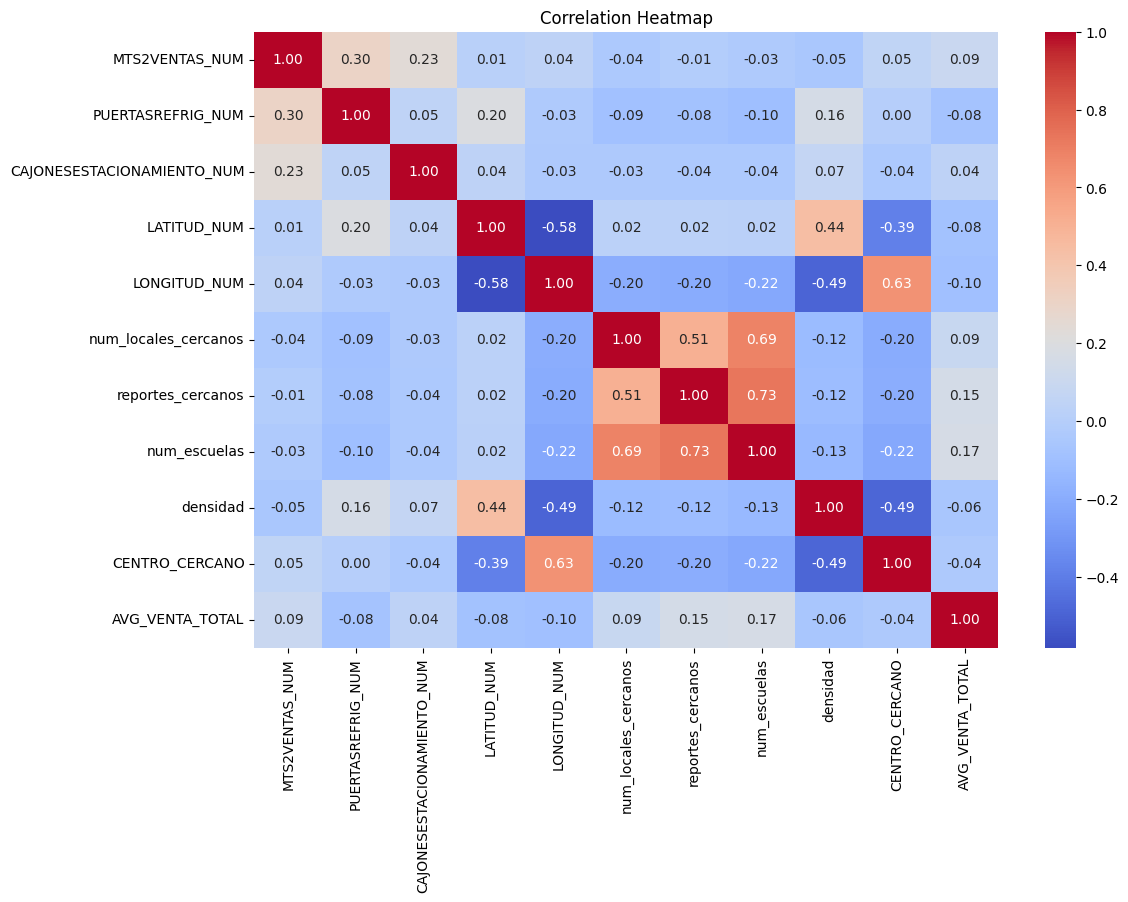

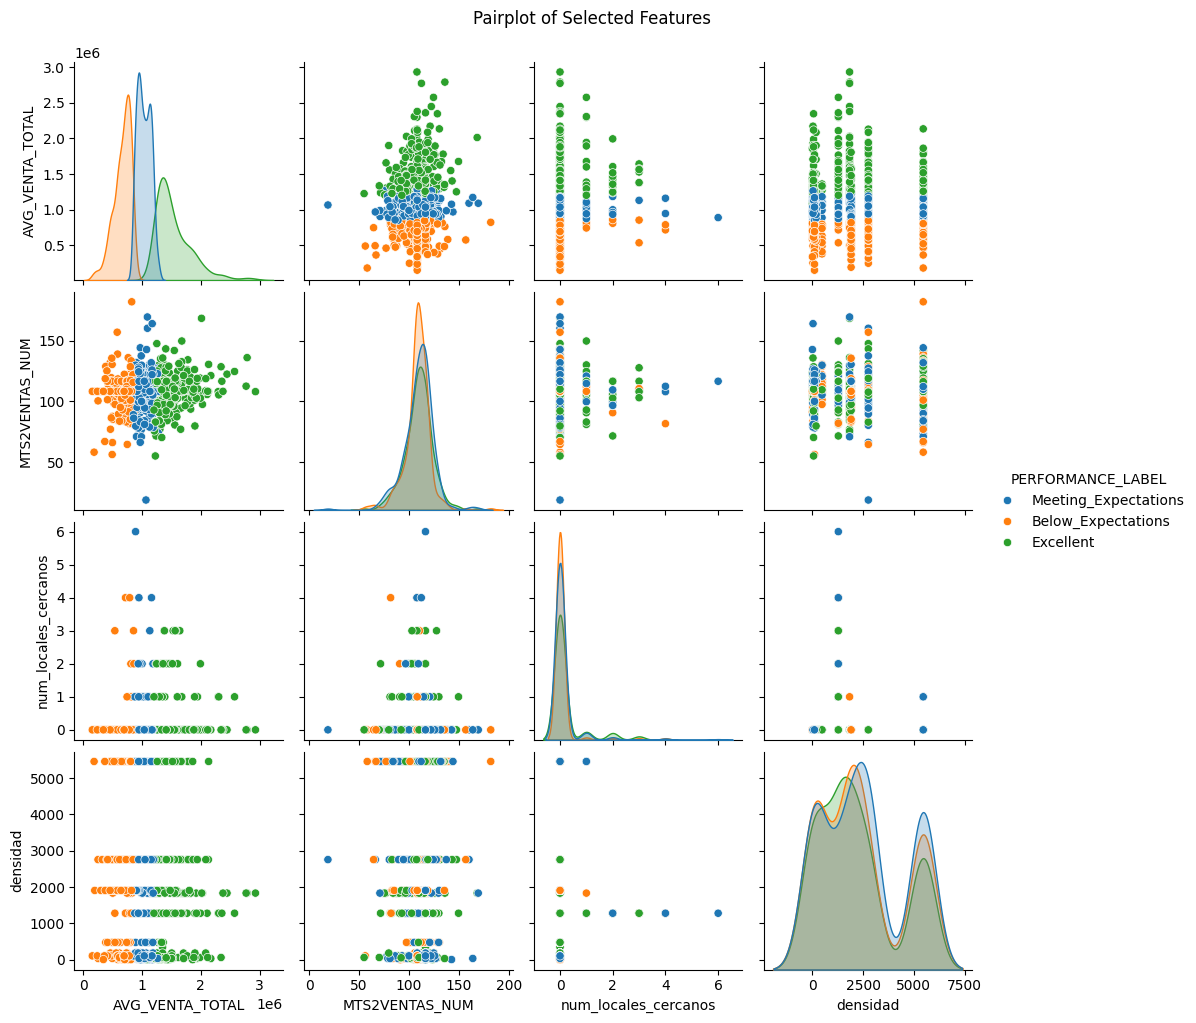

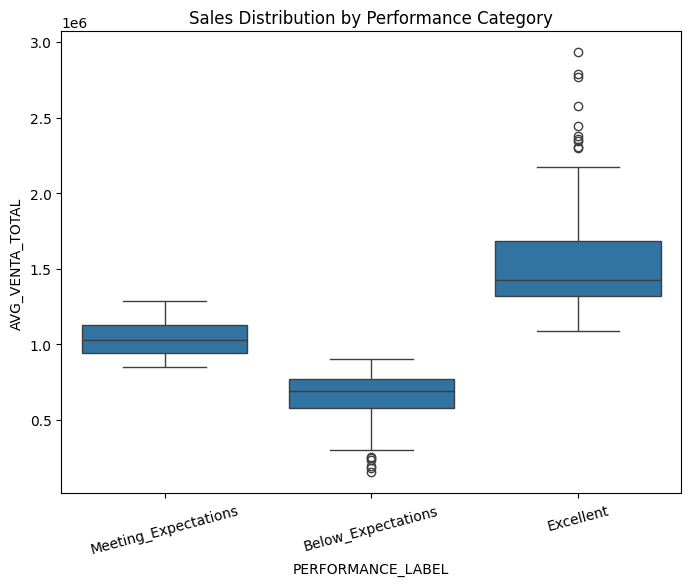

In [2]:

# 1. Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load data
df = pd.read_csv("classified(3).csv")

# 3. Define features and targets
X = df.drop(columns=["AVG_VENTA_TOTAL", "TIENDA_ID", "DATASET", "Meta_venta", "PERFORMANCE_LABEL"])
y_reg = df["AVG_VENTA_TOTAL"]
y_clf = df["PERFORMANCE_CATEGORY"]

# 4. Train/test split
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# 5. Define feature lists
numeric_features = [
    'MTS2VENTAS_NUM', 'PUERTASREFRIG_NUM', 'CAJONESESTACIONAMIENTO_NUM',
    'LATITUD_NUM', 'LONGITUD_NUM', 'num_locales_cercanos',
    'reportes_cercanos', 'num_escuelas', 'densidad', 'CENTRO_CERCANO'
]

categorical_features = [
    'PLAZA_CVE', 'NIVELSOCIOECONOMICO_DES', 'ENTORNO_DES',
    'SEGMENTO_MAESTRO_DESC', 'LID_UBICACION_TIENDA'
]

# 6. Preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    remainder='drop'
)
preprocessor.fit(X_train)

# 7. Classification pipeline
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
clf_pipeline.fit(X_train, y_clf_train)

# 8. Train regressors for each category
category_models = {}
X_train_transformed = preprocessor.transform(X_train)

for category in df["PERFORMANCE_CATEGORY"].unique():
    mask = (y_clf_train == category)
    X_cat = X_train_transformed[mask]
    y_cat = y_reg_train[mask]

    if len(y_cat) > 0:
        reg = GradientBoostingRegressor(random_state=42)
        reg.fit(X_cat, y_cat)
        category_models[category] = reg
        print(f"Trained model for category {category} on {len(y_cat)} samples.")
    else:
        print(f"No training data for category {category}")

# 9. Prediction function
def safe_predict(latitude, longitude):
    input_data = {
        'LATITUD_NUM': latitude,
        'LONGITUD_NUM': longitude,
    }

    for col in numeric_features:
        if col not in input_data:
            input_data[col] = X_train[col].median()
    for col in categorical_features:
        input_data[col] = X_train[col].mode()[0]

    input_df = pd.DataFrame([input_data])[numeric_features + categorical_features]

    try:
        category = clf_pipeline.predict(input_df)[0]
        category_proba = clf_pipeline.predict_proba(input_df)[0]

        if category in category_models:
            input_transformed = preprocessor.transform(input_df)
            prediction = category_models[category].predict(input_transformed)[0]
        else:
            prediction = y_reg_train.median()
            print(f"Warning: No model for category {category}, using median.")

        return category, prediction, category_proba
    except Exception as e:
        print("Prediction failed:", e)
        raise

# 10. Test prediction
print("\nTesting prediction function:")
test_coords = [
    (25.70486, -100.15613),
    (25.69107, -100.21261),
    (25.71883, -100.19133),
    (25.67955, -100.24328)
]
for lat, lon in test_coords:
    cat, pred, proba = safe_predict(lat, lon)
    print(f"Lat: {lat}, Lon: {lon} => Category: {cat}, Sales: ${pred:,.2f}")

# 11. Evaluation
print("\nEvaluation on test set:")
clf_accuracy = clf_pipeline.score(X_test, y_clf_test)
print(f"Classification accuracy: {clf_accuracy:.3f}")

X_test_transformed = preprocessor.transform(X_test)
for category in category_models.keys():
    mask = (y_clf_test == category)
    if mask.sum() > 0:
        X_cat = X_test_transformed[mask]
        y_cat = y_reg_test[mask]
        preds = category_models[category].predict(X_cat)
        r2 = r2_score(y_cat, preds)
        rmse = np.sqrt(mean_squared_error(y_cat, preds))
        print(f"Category {category}: R² = {r2:.3f}, RMSE = ${rmse:,.2f}")

# 12. Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_features + ['AVG_VENTA_TOTAL']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# 13. Pairplot (selected variables)
sns.pairplot(df, vars=['AVG_VENTA_TOTAL', 'MTS2VENTAS_NUM', 'num_locales_cercanos', 'densidad'], hue='PERFORMANCE_LABEL')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

# 14. Boxplot for sales by category
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='PERFORMANCE_LABEL', y='AVG_VENTA_TOTAL')
plt.title("Sales Distribution by Performance Category")
plt.xticks(rotation=15)
plt.show()
